<a href="https://colab.research.google.com/github/crux82/CLiC-it_2023_tutorial/blob/main/CLiC_it_2023_tutorial_ExtremITA_0_data_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CLiC-it 2023 Tutorial
# Large Language Models and How to Instruction Tune Them (in a Sustainable Way) - Step 1

**Authors**: C.D. Hromei & D. Croce

This is an implementation for training and using a Large Language Model (based on [LLaMA](https://ai.meta.com/blog/large-language-model-llama-meta-ai/)) with instructions in order to solve the linguistic tasks of [EVALITA](https://www.evalita.it/campaigns/evalita-2023/). In this lab, we will see how to encode datasets from any format to a sequence to sequence format, train the model using [Q-LoRA](https://arxiv.org/abs/2305.14314), perform the inference using the previous trained model for generating answers to instructions, and finally, how to encode back the data to the original format.. all of it using the only available *T4 GPU with 15GB from Google Colab*.

The tutorial is split into 4 steps, reflecting the aforementioned process:
- **Step 1 - Encoding the data**
- Step 2 - Training the LLaMA model
- Step 3 - Inference: generating answers
- Step 4 - Deconding the data

# Index:
1. Introduction, Workflow and Objectives
2. Preliminary steps
3. How to generate the dataset: encoding

## Step 1 - Encoding the data

In this Notebook we will see the encoding part of the data, given that we have some datasets each of which in its own format, in order to transform it into a sequence to sequence format. We will save the data on a file for next steps.

# The workflow

In EVALITA we have a lot of datasets (22 tasks), each of which in a different format. In this tutorial we will focus on the [CLinkaRT](https://e3c.fbk.eu/clinkart) task, which is in the PubTator format, as it is the only pubblicly available. The annotated data consists of a straightforward tab-delimited text file:


```
<DOCID>|t|<TEXT>
<DOCID>  REL  <RML_START>-<RML_END>  <EVENT_START>-<EVENT_END>  <RML_TEXT>  <EVENT_TEXT>
<DOCID>  REL  <RML_START>-<RML_END>  <EVENT_START>-<EVENT_END>  <RML_TEXT>  <EVENT_TEXT>

<DOCID>|t|<TEXT>
<DOCID>  REL  <RML_START>-<RML_END>  <EVENT_START>-<EVENT_END>  <RML_TEXT>  <EVENT_TEXT>
```

The **objective** here is to transform this data for the LLaMA model, so we need to:
1. Transform data into sequence-to-sequence format, in order to feed it to the LLaMA model:  
  a. Read original data with pandas  
  b. Take the text after `|t|` and save it  
  c. Parse every relation `REL` into a sequence
2. Save it on file

## Input
The "input" of the Notebook is a file in the PubTator format, as given from the challenge.

## Output
The "output" (i.e. the result) of this Notebook is a simple txt file delimited by tabs, with four columns:
- id
- task name, from which the natural language task description is generated
- input text
- expected output

## Preliminary Steps:

1.   Runtime SetUp
2.   Install Packages

### RunTime SetUp

Please make sure you are using the runtime environment according to the following settings:
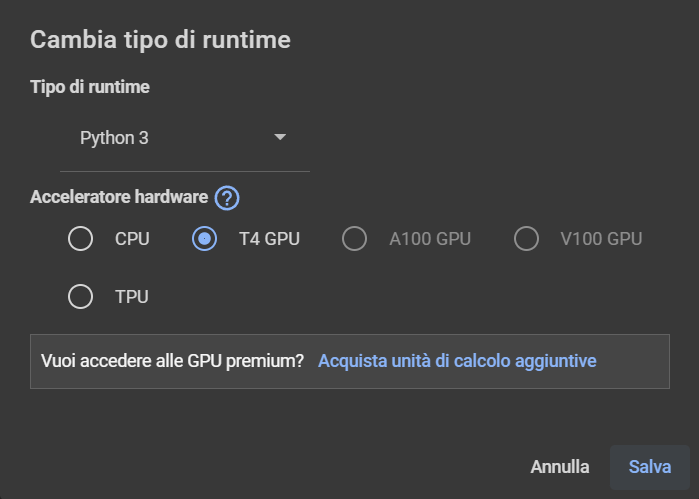

## Install packages

Tip: An initial "!" allows you to execute the rest if the code in the line as on the OS shell

In [ ]:
import random
from os.path import isdir
from os import mkdir
import spacy
import re

In [ ]:
import warnings
warnings.filterwarnings('ignore')

We will use the [Spacy](https://spacy.io/usage) framework for splitting the paragraphs into sentences by exploiting its submodules in the [language processing pipeline](https://spacy.io/usage/processing-pipelines). Here we download the italian news corpus.

In [ ]:
! python -m spacy download it_core_news_sm

### Handle external data:
<a href="https://colab.research.google.com/notebooks/io.ipynb">Here</a> you can find a guide on how to handle external data with Google Colab. We will import some file from my personal Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change this to match your path
data_path = "./drive/MyDrive/Colab Notebooks/PhD/CLiC-it 2023 tutorial/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# How to generate the dataset

We cannot share the EVALITA data for fine-tuning, you should access each individual site from the [task page](https://www.evalita.it/campaigns/evalita-2023/tasks/) of EVALITA and request to download the data. After downloading it, put them in the associated folder: e.g., you should put the "Clinkart" data in `/data/CLinkART` divided by subtask, etc.  
Once you have collected all the data you can encode them into the dataset format for our model, using the `encode` function.  
[On our Github repository](https://github.com/crux82/ExtremITA/tree/main/tasks) you can find all the others, but we report the `encoder` only for the CLinkaRT task:

In [ ]:
nlp = spacy.load("it_core_news_sm", disable=["lemmatizer", "tagger"])

TASK = "clinkart"
TRAIN_DEV_SPLIT = 0.05

random.seed(23)

# retrieve the offsets for the relations
def get_offset_from_split(text, MIN_CHARS= 50, MAX_TOKENS = 30):
    res = []
    l = 0
    newsent = {
        "from": 0,
        "to": 0
    }

    doc = nlp(text)

    sentences = [sent for sent in doc.sents]

    for s_id, sent in enumerate(sentences):

        if newsent["to"] - newsent["from"] < MIN_CHARS or l + len(sent) < MAX_TOKENS:
            newsent = {
                "from": newsent["from"],
                "to": sent.end_char
            }
            l = l + len(sent)
        else:
            res.append(newsent)
            newsent = {
                "from": sent.start_char,
                "to": sent.end_char
            }
            l = len(sent)

        # if last sentence is alone, add it as it is
        if s_id == len(sentences) - 1:
            res.append(newsent)

    return res

def encode():
    data = dict()
    file_name = f"{data_path}/clinkart_dataset.txt"

    with open(file_name, encoding="utf-8") as f:
        sentences = dict()
        for line in f:
            if line != "\n":
                if "|t|" in line:
                    document_id = line.split("|")[0]
                    text = "|".join(line.split("|")[2:]).strip()
                    sentences[document_id] = get_offset_from_split(text)
                else:
                    document_id, _, span1, span2, tokens1, tokens2 = line.strip().split("\t")
                    from1, to1 = map(eval, span1.split("-"))
                    from2, to2 = map(eval, span2.split("-"))
                    for sent in sentences[document_id]:
                        # final sentence_id will be the document id concatenated with the starting and ending token index of the sentence
                        sentence_id = f"{document_id}_{sent['from']}_{sent['to']}"
                        # initialize object for the sentence
                        if sentence_id not in data.keys():
                            data[sentence_id] = {
                                'text': text[sent["from"]:sent["to"]],
                                "relations": []
                            }
                        # if the span of the tokens is contained in this sentence, add the relation
                        if min(from1, from2) >= sent["from"] and max(to1, to2) <= sent["to"]:
                            data[sentence_id]['relations'].append((from1, tokens1, tokens2, "RML", "EVENT"))

    with open(f"{data_path}/clinkart_train.txt", "w", encoding="utf-8") as f_train, \
         open(f"{data_path}/clinkart_dev.txt", "w", encoding="utf-8") as f_dev:
        for id, item in data.items():
            label = ""

            relations = item["relations"]
            relations = sorted(relations, key=lambda from_id: from_id[0])
            for relation in relations:
                _, tokens1, tokens2, _, _ = relation
                label += f" [BREL] {tokens1} [SEP] {tokens2} [EREL]"

            # if the relations field is empty the label is [NOREL]
            label = label.lstrip() if relations else "[NOREL]"
            line = f"{id}\t{TASK}\t{item['text']}\t{label}\n"

            if id.startswith(TASK) and random.random()<TRAIN_DEV_SPLIT:
                f_dev.write(line)
            else:
                f_train.write(line)

It will generate a file for the task. In order to fine-tune the model you should merge them into one single file and split them into `train.txt` and `dev.txt`. Here we will use a subset of the training, with 100 examples per task.  
These files are made of 4 columns (with a tab character as a delimiter) without any header:
- id
- task name, from which the natural language task description is generated
- input text
- expected output

In [ ]:
with open(f"{data_path}/clinkart_dataset.txt", "r") as f:
  lines = f.readlines()
  for i, line in enumerate(lines):
    print(line)
    if i > 3:
      break

100002|t|Anna è una donna di 47 anni, vive con il figlio in un piccolo appartamento in un paese carsico, lavora nel campo della ristorazione e, nonostante una patologia genetica familiare che provoca delle alterazioni scheletriche, cardiologiche, oculari e cutanee, vive una vita serena e tranquilla. Ha una buona rete familiare e informale che supporta la famiglia. Viene seguita da un centro di riferimento specifico per patologia rara a Bologna e si sottopone a controlli clinicostrumentali periodici e regolari. Nel gennaio del 2017 esegue un intervento chirurgico di piede torto congenito presso l’Istituto Rizzoli. Durante la degenza, a seguito di un dolore retrosternale e di una sincope, viene sottoposta a un intervento di endoprotesi di aorta per dissezione acuta. Al rientro a casa, nel marzo del 2017, deve proseguire i controlli cardiologici ed eseguire la fisioterapia per gli esiti di intervento al piede e regolari controlli ematici. Non essendo autonoma nella deambulazione, viene pr

In [ ]:
encode()

Let's open the newly created file and see what's inside

In [ ]:
with open(f"{data_path}/clinkart_train.txt", "r") as f:
  lines = f.readlines()
  print(lines[0])
  print(lines[8])

100002_0_291	clinkart	Anna è una donna di 47 anni, vive con il figlio in un piccolo appartamento in un paese carsico, lavora nel campo della ristorazione e, nonostante una patologia genetica familiare che provoca delle alterazioni scheletriche, cardiologiche, oculari e cutanee, vive una vita serena e tranquilla.	[NOREL]

100002_1273_1404	clinkart	Si somministra la scheda PHE-S® per una valutazione dell’elaborazione del vissuto della malattia, riscontrando un punteggio di 2,5.	[BREL] un punteggio di 2,5 [SEP] valutazione [EREL] [BREL] un punteggio di 2,5 [SEP] PHE-S [EREL]



## Encoding all the datasets
We saw how to encode one datasets (CLinkaRT), but if you want to encode all the others [here](https://github.com/crux82/ExtremITA/tree/main/tasks) you can find the list with the links to the code. Each specific encoder will produce a train and dev file. In the end, you need to merge all of them together and get the training and development set!

If you clone the Github Repository, you can exploit the `encode` method in the root to automatically encode each dataset. You need first to download them from each Task page and put them in the right folder.

- [acti](https://github.com/crux82/ExtremITA/blob/main/tasks/acti.py)
- [clinkart](https://github.com/crux82/ExtremITA/blob/main/tasks/clinkart.py)
- [discotex](https://github.com/crux82/ExtremITA/blob/main/tasks/discotex.py)
- [emit](https://github.com/crux82/ExtremITA/blob/main/tasks/emit.py)
- [emotivita](https://github.com/crux82/ExtremITA/blob/main/tasks/emotivita.py)
- [geolingit](https://github.com/crux82/ExtremITA/blob/main/tasks/geolingit.py)
- [haspeede](https://github.com/crux82/ExtremITA/blob/main/tasks/haspeede.py)
- [hodi](https://github.com/crux82/ExtremITA/blob/main/tasks/hodi.py)
- [langlearn](https://github.com/crux82/ExtremITA/blob/main/tasks/langlearn.py)
- [multifakedetective](https://github.com/crux82/ExtremITA/blob/main/tasks/multifakedetective.py)
- [nermud](https://github.com/crux82/ExtremITA/blob/main/tasks/nermud.py)
- [politicit](https://github.com/crux82/ExtremITA/blob/main/tasks/politicit.py)
- [wicita](https://github.com/crux82/ExtremITA/blob/main/tasks/wicita.py)



### Next step
[Step 2 - Training the LLaMA Model](https://colab.research.google.com/drive/1tB8Qa9zuhantLrfZMPNsKnYWuWB1UTDP?usp=sharing)